# Care Disparity Project
Pulling tradional demographic labels and SDoH and linking them to disparity outcomes using MIMIC data. 

Codes drawn from: https://github.com/jhn-nt/disparity_maps  
Data from: https://physionet.org/content/mimiciv/2.2/ 

## Imports and Downloading Data

###Imports

In [1]:
from google.colab import auth
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
auth.authenticate_user()

### Download Data

In [3]:
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'mimic-practice-377718' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [6]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_19a0c4a4_18812c599fc') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results.head()

,subject_id,hadm_id,stay_id,intime,outtime,los,time_to_intubation_hour,age,height,weight,...,time_to_first_oral_care__toothbrush,number_of_oral_care__deferred,frequency_of_oral_care_hour__deferred,time_to_first_oral_care__deferred,number_of_oral_care__oral_care_kit_severe,frequency_of_oral_care_hour__oral_care_kit_severe,time_to_first_oral_care__oral_care_kit_severe,number_of_oral_care__oral_care_kit_mild,frequency_of_oral_care_hour__oral_care_kit_mild,time_to_first_oral_care__oral_care_kit_mild
0,10004113,29879900,35200789,2173-03-20 20:16:36,2173-03-21 21:43:59,1.060683,NaN,33,None,79.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10018328,23786647,31269608,2154-04-24 23:03:44,2154-05-02 15:55:21,7.702512,NaN,83,None,59.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10019607,24546857,34178938,2167-03-19 17:37:39,2167-03-21 13:12:28,1.815845,NaN,20,None,71.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10023994,21824032,30439823,2146-07-19 15:32:22,2146-07-20 14:05:53,0.939942,NaN,38,None,87.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10028930,26238833,33941522,2172-08-28 13:11:37,2172-08-29 14:19:35,1.047199,NaN,65,None,95.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Frequency')

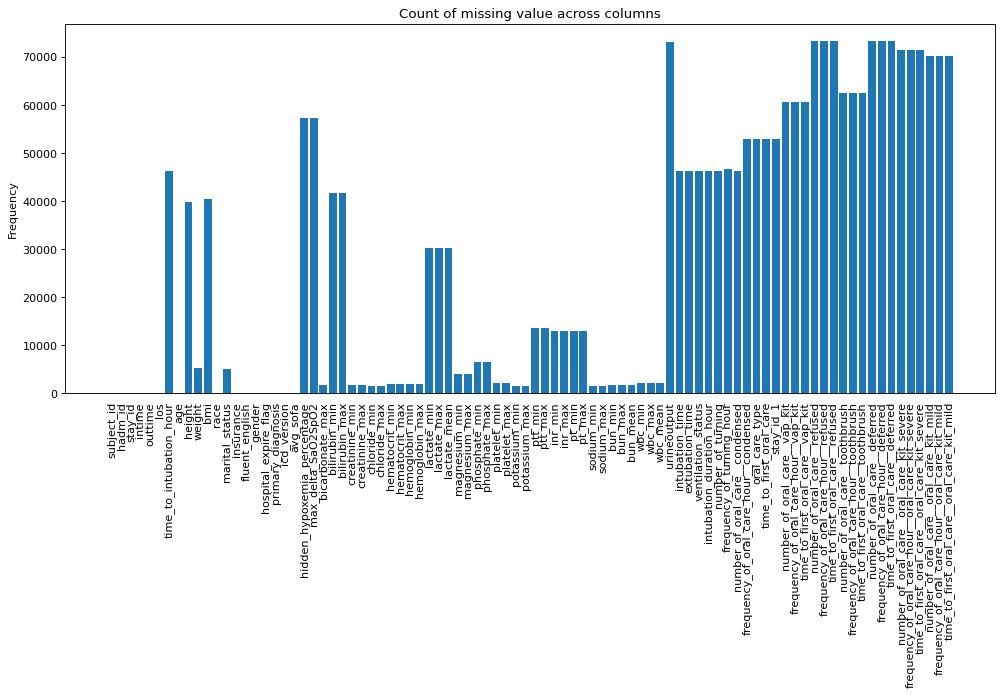

In [12]:
from matplotlib.pyplot import figure
import matplotlib.font_manager

figure(figsize=(15, 6), dpi=80)
plt.bar(list(results.columns), list(results.isna().sum()));
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True);
plt.xticks(rotation=90)
plt.title('Count of missing value across columns')
plt.ylabel('Frequency')

In [13]:
results['race'] = results['race'].replace(['ASIAN - CHINESE', 'ASIAN - KOREAN', 'ASIAN', 'ASIAN - SOUTH EAST ASIAN',
                                           'ASIAN - ASIAN INDIAN'], 'ASIAN')
results['race'] = results['race'].replace(['HISPANIC/LATINO - DOMINICAN', 'HISPANIC OR LATINO','HISPANIC/LATINO - MEXICAN',
                                           'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - GUATEMALAN',
                                           'HISPANIC/LATINO - SALVADORAN','HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - CENTRAL AMERICAN',
                                           'HISPANIC/LATINO - HONDURAN'], 'HISPANIC/LATINO')
results['race'] = results['race'].replace(['WHITE', 'WHITE - OTHER EUROPEAN', 'WHITE - BRAZILIAN', 'WHITE - RUSSIAN','BLACK/AFRICAN',
                                           'WHITE - EASTERN EUROPEAN'], 'WHITE')
results['race'] = results['race'].replace(['MULTIPLE RACE/ETHNICITY'], 'MULTIRACIAL')
results['race'] = results['race'].replace(['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND'], "BLACK OR AFRICAN AMERICAN")
results['race'] = results['race'].replace(['UNKNOWN', 'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN'], "MISSING, UNKNOWN, OR DECLINED")

In [16]:
#!pip install openpyxl
#!pip install tableone
from tableone import TableOne

demographic=["height","weight","bmi","age","race",
             "marital_status","insurance","fluent_english","gender",
             "avg_sofa", "hidden_hypoxemia_percentage",
             "max_delta_SaO2SpO2", "intubation_duration_hour",
             'time_to_intubation_hour', "number_of_turning",
             "frequency_of_turning_hour", "number_of_oral_care__condensed",
             "frequency_of_oral_care_hour__condensed", "oral_care_type"]

categorical=[
    "hospital_expire_flag",
    "insurance",
    "race",
    "fluent_english",
    "marital_status",
    "gender",
    "bmi_class",
    "diag_1_name",
    "diag_2_name",
    "diag_1_icd_code",
    "diag_2_icd_code",
    "diag_1_icd_version",
    "diag_2_icd_version",
    "oral_care_type"]

table=TableOne(results,
         columns=demographic,
         categorical=list(set(demographic).intersection(categorical)),
         groupby="hospital_expire_flag")
table

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tableone/tableone.py:932: FutureWarning: ['number_of_turning', 'number_of_oral_care__condensed'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_cont = cont_data.apply(aggfuncs).T  # type: ignore
/usr/local/lib/python3.10/dist-packages/tableone/tableone.py:927: FutureWarning: ['number_of_turning', 'number_of_oral_care__condensed'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_cont = pd.pivo

Grouped by hospital_expire_flag                                                    
                                                                                                                        Missing          Overall                0                 1
n                                                                                                                                          73159            64836              8323
height, mean (SD)                                                                                                         39695     169.5 (10.8)     169.6 (10.7)      168.2 (10.8)
weight, mean (SD)                                                                                                          5356      81.1 (34.1)      81.6 (35.1)       77.4 (23.8)
bmi, mean (SD)                                                                                                            40299       28.7 (7.7)       28.8 (7.6)        28.0 (8.1)
age, mean (SD)                                                                                                                0      64.7 (16.9)      63.9 (16.9)       70.5 (15.2)
race, n (%)                                       AMERICAN INDIAN/ALASKA NATIVE                                               0        140 (0.2)        126 (0.2)          14 (0.2)
                                                  ASIAN                                                                               2155 (2.9)       1890 (2.9)         265 (3.2)
                                                  BLACK OR AFRICAN AMERICAN                                                          7648 (10.5)      6931 (10.7)         717 (8.6)
                                                  HISPANIC/LATINO                                                                     2740 (3.7)       2517 (3.9)         223 (2.7)
                                                  MISSING, UNKNOWN, OR DECLINED                                                      7680 (10.5)       6188 (9.5)       1492 (17.9)
                                                  MULTIRACIAL                                                                           68 (0.1)         61 (0.1)           7 (0.1)
                                                  NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER                                            110 (0.2)         92 (0.1)          18 (0.2)
                                                  OTHER                                                                               2367 (3.2)       2115 (3.3)         252 (3.0)
                                                  PORTUGUESE                                                                           321 (0.4)        284 (0.4)          37 (0.4)
                                                  SOUTH AMERICAN                                                                        64 (0.1)         59 (0.1)           5 (0.1)
                                                  WHITE                                                                             49866 (68.2)     44573 (68.7)       5293 (63.6)
marital_status, n (%)                             DIVORCED                                                                 5111       5404 (7.9)       4862 (8.0)         542 (7.6)
                                                  MARRIED                                                                           32762 (48.1)     29309 (48.1)       3453 (48.2)
                                                  SINGLE                                                                            20848 (30.6)     18989 (31.2)       1859 (26.0)
                                                  WIDOWED                                                                            9034 (13.3)      7726 (12.7)       1308 (18.3)
insurance, n (%)                                  Medicaid                                                                    0       55

In [18]:
#table.to_excel('TableOne.xlsx')
#table.to_latex()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Select Features to keep 
df = results.copy()
# keep only the following columns:
features_to_keep = [
    'subject_id', 'hadm_id', 'stay_id', 'los', 'age', 'height', 'weight', 'bmi', 'race', 'marital_status', 'insurance',
    'fluent_english', 'gender', 'hospital_expire_flag', 'primary_diagnosis',
    'icd_version', 'avg_sofa', 'hidden_hypoxemia_percentage',
    'max_delta_SaO2SpO2', 'intubation_duration_hour', 'number_of_turning',
    'frequency_of_turning_hour', 'number_of_oral_care__condensed',
    'frequency_of_oral_care_hour__condensed', 'oral_care_type']

df = df[features_to_keep]
df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,subject_id,hadm_id,stay_id,los,age,height,weight,bmi,race,marital_status,...,icd_version,avg_sofa,hidden_hypoxemia_percentage,max_delta_SaO2SpO2,intubation_duration_hour,number_of_turning,frequency_of_turning_hour,number_of_oral_care__condensed,frequency_of_oral_care_hour__condensed,oral_care_type
0,10004113,29879900,35200789,1.060683,33,None,79.4,NaN,WHITE,MARRIED,...,10,0.541667,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,None
1,10018328,23786647,31269608,7.702512,83,None,59.8,NaN,WHITE,DIVORCED,...,10,1.375000,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,None
2,10019607,24546857,34178938,1.815845,20,None,71.4,NaN,"MISSING, UNKNOWN, OR DECLINED",SINGLE,...,10,1.875000,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,None
3,10023994,21824032,30439823,0.939942,38,None,87.7,NaN,"MISSING, UNKNOWN, OR DECLINED",SINGLE,...,10,0.636364,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,None
4,10028930,26238833,33941522,1.047199,65,None,95.6,NaN,ASIAN,None,...,10,1.000000,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73154,19998330,24492004,32641669,2.607037,72,None,77.1,NaN,BLACK OR AFRICAN AMERICAN,MARRIED,...,9,4.000000,NaN,NaN,30.866667,14,0.453564,1,0.032397,Toothbrush (No observed alteration)
73155,19998878,26489544,34403689,0.741794,56,183.000000000,90.0,26.874496,WHITE,SINGLE,...,9,6.235294,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,None
73156,19999068,21606769,30143796,6.765324,63,170.000000000,55.8,19.307958,WHITE,DIVORCED,...,9,4.125000,NaN,NaN,67.416667,34,0.504326,5,0.074166,Toothbrush (No observed alteration)
73157,19999287,20175828,35165301,4.705752,77,165.000000000,86.2,31.662075,BLACK OR AFRICAN AMERICAN,SINGLE,...,9,0.958333,0.0,1.0,18.000000,7,0.388889,1,0.055556,Toothbrush (No observed alteration)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


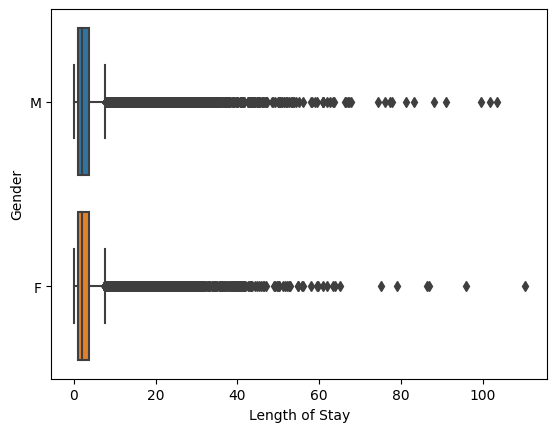

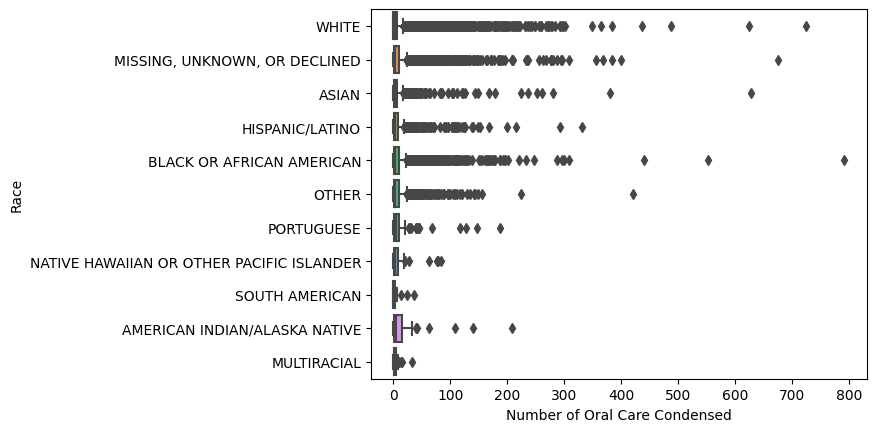

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y='gender', x='los', data=df, orient='h')

# Set x and y labels
plt.xlabel('Length of Stay')
plt.ylabel('Gender')
plt.show()

sns.boxplot(y='race', x='number_of_oral_care__condensed', data=df, orient='h')

# Set x and y labels
plt.xlabel('Number of Oral Care Condensed')
plt.ylabel('Race')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


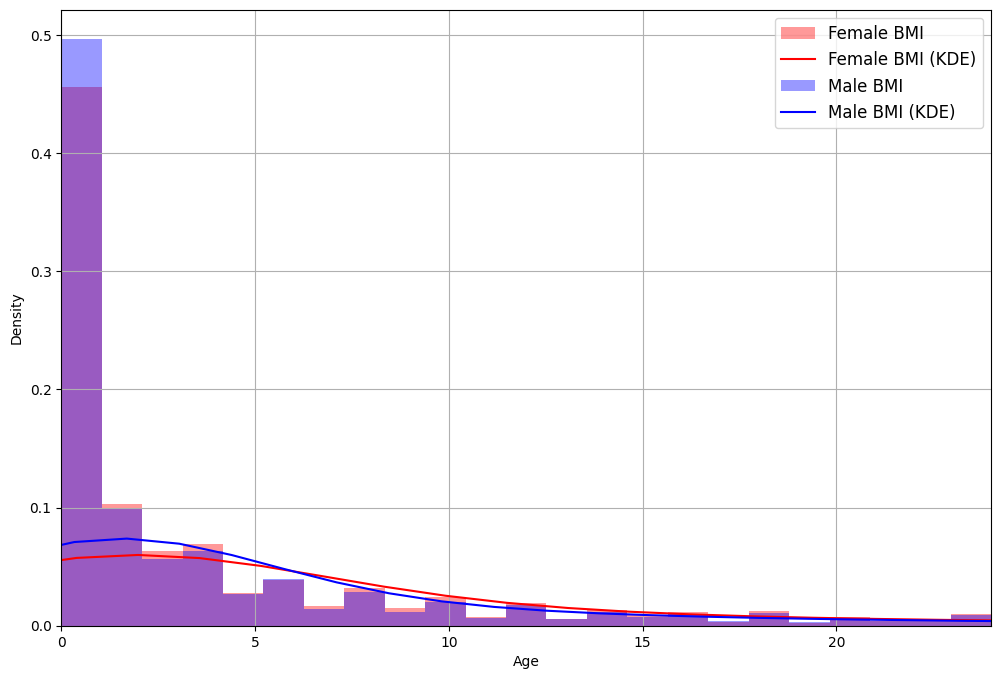

<Figure size 640x480 with 0 Axes>

In [21]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(12, 8), sharey=True)
plt.rcParams.update({'font.size': 12})
bin_min = 0
bin_max = 24
bins = np.linspace(bin_min, bin_max, 24)

df.loc[df["gender"] == "F"].number_of_oral_care__condensed.hist(bins=bins, ax=ax, alpha=0.4, label='Female BMI', density=True, color='red')
df.loc[df["gender"] == "F"].number_of_oral_care__condensed.plot.kde(ax=ax, color='red', label='Female BMI (KDE)')
df.loc[df["gender"] == "M"].number_of_oral_care__condensed.hist(bins=bins, ax=ax, alpha=0.4, label='Male BMI', density=True, color='blue')
df.loc[df["gender"] == "M"].number_of_oral_care__condensed.plot.kde(ax=ax, color='blue', label='Male BMI (KDE)')
ax.set_xlim(bin_min, bin_max)
ax.set_xlabel("Age")
ax.grid()
ax.legend()
plt.show()
plt.tight_layout()


## Data Exploration 

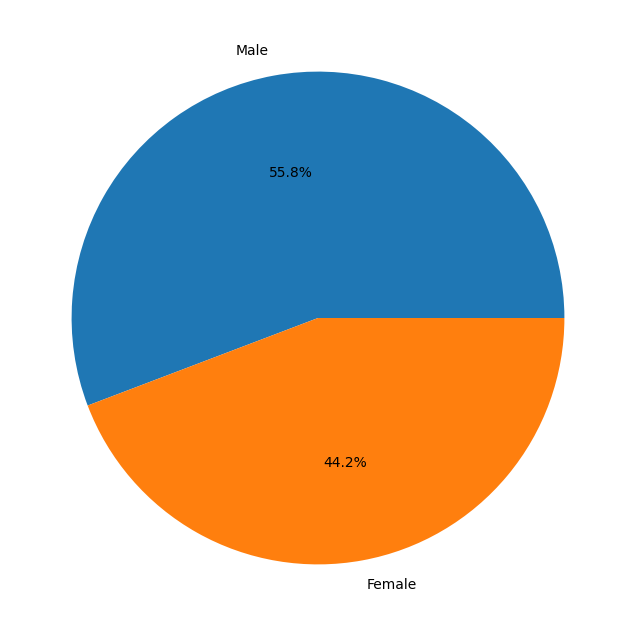

In [ ]:
# Gender Distribution 
import matplotlib.pyplot as plt
import numpy as np
count = df['gender'].value_counts(dropna=False)

plt.pie(count, labels=["Male", "Female"], autopct='%1.1f%%')
plt.show()

1.0    65717
0.0     7442
Name: fluent_english, dtype: int64


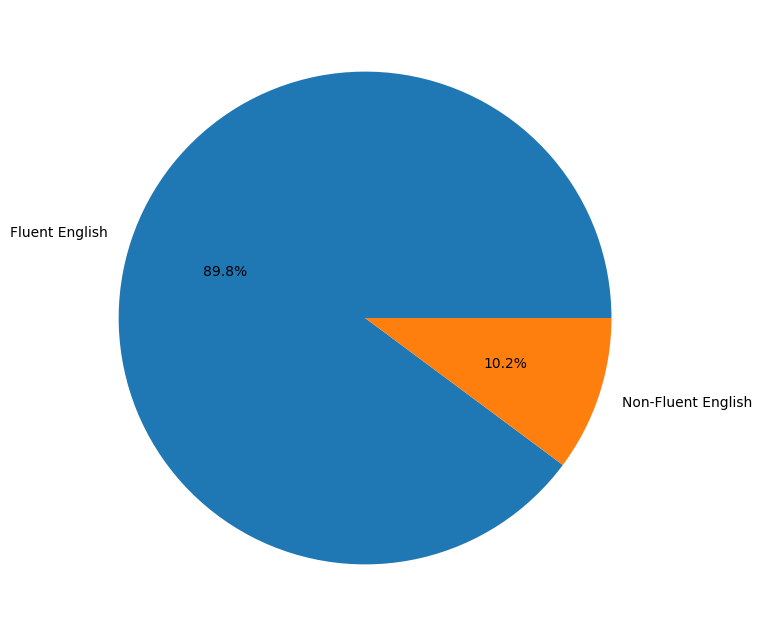

In [ ]:
# Fluency in English 
count = df['fluent_english'].value_counts(dropna=False)
print(count)
plt.pie(count, labels=["Fluent English", "Non-Fluent English"], autopct='%1.1f%%')
plt.show()

2.0    49557
0.0    15645
1.0     7957
Name: race, dtype: int64


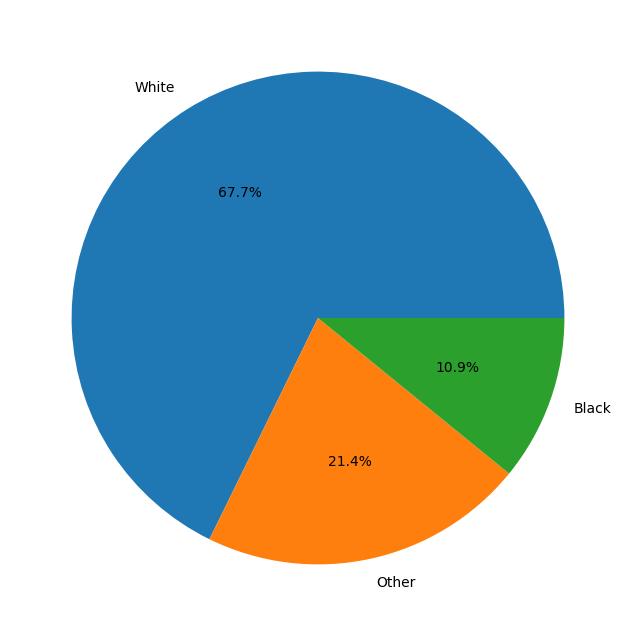

In [ ]:
# Race 
import matplotlib.pyplot as plt
import numpy as np
count = df['race'].value_counts(dropna=False)
print(count)
plt.pie(count, labels=["White", "Other", "Black"], autopct='%1.1f%%')
plt.show()

In [ ]:
# Number of pts on Vents ???? UNSURE HOW TO DO THIS 
count = df['intubation_duration_hour'].value_counts()
count.isna().sum()

0

In [ ]:
# Missingness of the df 
missingness = {}
percent_missing = {}
for col in df.columns:
  missingness[col] = df[col].isna().sum()
  percent_missing[col] = df[col].isna().sum() / df[col].count()

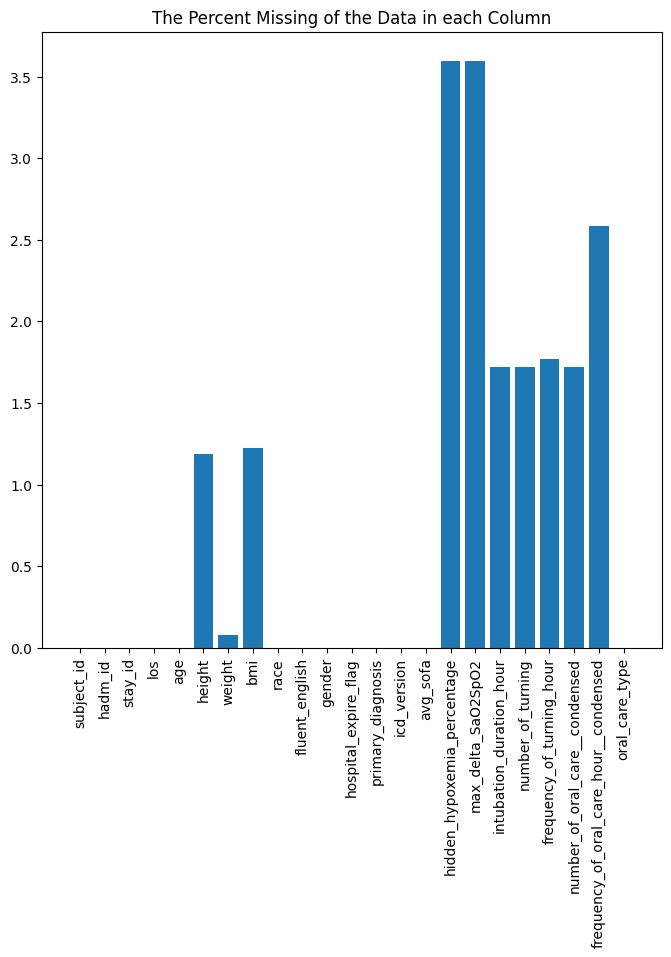

In [ ]:
# Plot percent missing 
plt.bar(*zip(*percent_missing.items()))
plt.xticks(rotation=90)
plt.title("The Percent Missing of the Data in each Column")
plt.show()

In [ ]:
# Descriptive Stats on Columns
stats = df.describe()
stats

,subject_id,hadm_id,stay_id,los,age,height,weight,bmi,race,fluent_english,...,icd_version,avg_sofa,hidden_hypoxemia_percentage,max_delta_SaO2SpO2,intubation_duration_hour,number_of_turning,frequency_of_turning_hour,number_of_oral_care__condensed,frequency_of_oral_care_hour__condensed,oral_care_type
count,7.315900e+04,7.315900e+04,7.315900e+04,73159.000000,73159.000000,33464.000000,67803.000000,32860.000000,73159.000000,73159.000000,...,73159.000000,73141.000000,15921.000000,15921.000000,26878.000000,26878.000000,26428.000000,26878.000000,20396.000000,73159.000000
mean,1.499784e+07,2.498106e+07,3.499277e+07,3.451945,64.677634,169.454685,81.129210,28.663528,1.463538,0.898276,...,9.406908,3.453624,0.026767,821.757358,52.254099,22.709093,0.464343,10.059863,0.189602,0.979620
std,2.885968e+06,2.884504e+06,2.889354e+06,4.922969,16.879494,10.754872,34.091722,7.685396,0.822422,0.302287,...,0.491261,2.796779,0.133869,28561.321123,89.694858,38.619438,0.362259,27.473069,0.180372,0.591808
min,1.000003e+07,2.000009e+07,3.000015e+07,0.001250,18.000000,122.000000,1.000000,0.245074,0.000000,0.000000,...,9.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.017857,0.000000,0.006667,0.000000
25%,1.249120e+07,2.248182e+07,3.248945e+07,1.084225,54.000000,163.000000,65.200000,23.836735,1.000000,1.000000,...,9.000000,1.130435,0.000000,2.000000,8.500000,4.000000,0.385707,1.000000,0.077941,1.000000
50%,1.499892e+07,2.496953e+07,3.499384e+07,1.926701,66.000000,170.000000,77.900000,27.426070,2.000000,1.000000,...,9.000000,2.833333,0.000000,3.000000,19.000000,8.000000,0.449977,2.000000,0.142857,1.000000
75%,1.751317e+07,2.747186e+07,3.748855e+07,3.713391,77.000000,178.000000,92.800000,32.001608,2.000000,1.000000,...,10.000000,4.958333,0.000000,5.000000,54.000000,23.000000,0.504739,8.000000,0.250000,1.000000
max,1.999999e+07,2.999983e+07,3.999981e+07,110.232280,102.000000,226.000000,5864.000000,266.332180,2.000000,1.000000,...,10.000000,20.750000,1.000000,999911.000000,1917.500000,765.000000,30.000000,792.000000,10.000000,4.000000
